In [43]:
import multiprocess as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
import gc
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
font = {'size': 16}
matplotlib.rc('font', **font)
import scipy

In [2]:
def create_land_prices_df():
    basedir = './공시지가/'
    filenames = [f for f in os.listdir(basedir) if f.endswith('.csv')]
    
    df = pd.read_csv(basedir + filenames[0], encoding='euc-kr', usecols=[2,4,5,6,8,10])
    
    df = df[df['기준년도'] >= 2013]
    
    df.drop_duplicates(subset=['법정동명', '특수지구분명', '지번', '기준년도'])
    
    return df

In [3]:
land_prices_df = create_land_prices_df()
print(land_prices_df.shape)
land_prices_df.head()

(7436007, 6)


,법정동명,특수지구분명,지번,기준년도,공시지가,표준지여부
23,서울특별시 종로구 청운동,일반,1,2013,2840000,N
24,서울특별시 종로구 청운동,일반,1,2014,2933000,N
25,서울특별시 종로구 청운동,일반,1,2015,3053000,N
26,서울특별시 종로구 청운동,일반,1,2016,3234000,N
27,서울특별시 종로구 청운동,일반,1,2017,3488000,N


In [4]:
land_prices_df['특수지구분명'].value_counts()

일반    7309817
산      126190
Name: 특수지구분명, dtype: int64

In [5]:
def landnum_modifier(x):
    # x is a string
    
    splitted = x.split('-')
    if len(splitted) == 1:
        return x+'-0'
    elif len(splitted) == 2:
        return x
    else:
        raise ValueError('myerror')

In [6]:
land_prices_df['지번주소'] = land_prices_df['법정동명'] + ' ' + land_prices_df['지번'].apply(landnum_modifier)
land_prices_df.head()

,법정동명,특수지구분명,지번,기준년도,공시지가,표준지여부,지번주소
23,서울특별시 종로구 청운동,일반,1,2013,2840000,N,서울특별시 종로구 청운동 1-0
24,서울특별시 종로구 청운동,일반,1,2014,2933000,N,서울특별시 종로구 청운동 1-0
25,서울특별시 종로구 청운동,일반,1,2015,3053000,N,서울특별시 종로구 청운동 1-0
26,서울특별시 종로구 청운동,일반,1,2016,3234000,N,서울특별시 종로구 청운동 1-0
27,서울특별시 종로구 청운동,일반,1,2017,3488000,N,서울특별시 종로구 청운동 1-0


In [7]:
land_prices_df = land_prices_df[['지번주소', '특수지구분명', '표준지여부', '기준년도', '공시지가']]

In [8]:
land_prices_df.head()

,지번주소,특수지구분명,표준지여부,기준년도,공시지가
23,서울특별시 종로구 청운동 1-0,일반,N,2013,2840000
24,서울특별시 종로구 청운동 1-0,일반,N,2014,2933000
25,서울특별시 종로구 청운동 1-0,일반,N,2015,3053000
26,서울특별시 종로구 청운동 1-0,일반,N,2016,3234000
27,서울특별시 종로구 청운동 1-0,일반,N,2017,3488000


In [9]:
land_prices_df.rename(columns={'기준년도':'년'}, inplace=True)

In [10]:
def san_addr_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        splitted = x.split(' ')
        return splitted[0] + ' ' + splitted[1] + ' ' + splitted[2] + ' 산' + splitted[3]

In [11]:
san_df = land_prices_df[land_prices_df['특수지구분명'] == '산']

In [12]:
san_df['지번주소'] = san_df['지번주소'].apply(san_addr_modifier)

In [13]:
san_df['지번주소'].unique()[:20]

array(['서울특별시 종로구 청운동 산1-1', '서울특별시 종로구 청운동 산1-13', '서울특별시 종로구 청운동 산1-36',
       '서울특별시 종로구 청운동 산1-76', '서울특별시 종로구 청운동 산1-77',
       '서울특별시 종로구 청운동 산1-79', '서울특별시 종로구 청운동 산1-83',
       '서울특별시 종로구 청운동 산1-84', '서울특별시 종로구 청운동 산4-11',
       '서울특별시 종로구 청운동 산4-15', '서울특별시 종로구 청운동 산4-34',
       '서울특별시 종로구 청운동 산4-35', '서울특별시 종로구 청운동 산4-36',
       '서울특별시 종로구 청운동 산4-38', '서울특별시 종로구 청운동 산4-39',
       '서울특별시 종로구 청운동 산4-41', '서울특별시 종로구 청운동 산4-56', '서울특별시 종로구 청운동 산7-2',
       '서울특별시 종로구 청운동 산7-14', '서울특별시 종로구 청운동 산7-15'], dtype=object)

In [14]:
land_prices_df.loc[san_df.index, '지번주소'] = san_df['지번주소']

In [15]:
del san_df

In [16]:
land_prices_df.drop(columns=['특수지구분명'], inplace=True)

In [17]:
print(land_prices_df.shape)
land_prices_df.drop_duplicates(subset=['지번주소', '년'], keep='first', inplace=True)
land_prices_df.shape

(7436007, 4)


(7422790, 4)

In [18]:
land_prices_df.head()

,지번주소,표준지여부,년,공시지가
23,서울특별시 종로구 청운동 1-0,N,2013,2840000
24,서울특별시 종로구 청운동 1-0,N,2014,2933000
25,서울특별시 종로구 청운동 1-0,N,2015,3053000
26,서울특별시 종로구 청운동 1-0,N,2016,3234000
27,서울특별시 종로구 청운동 1-0,N,2017,3488000


서울특별시 종로구 청운동 1-0


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


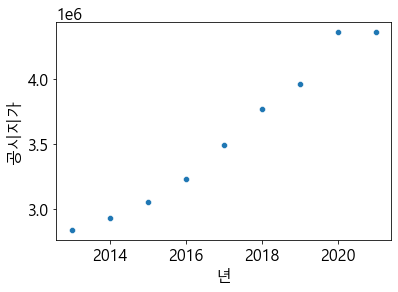

서울특별시 종로구 청운동 1-1


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


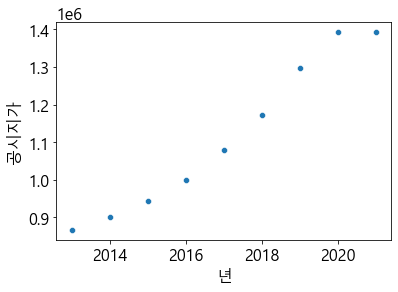

서울특별시 종로구 청운동 1-2


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


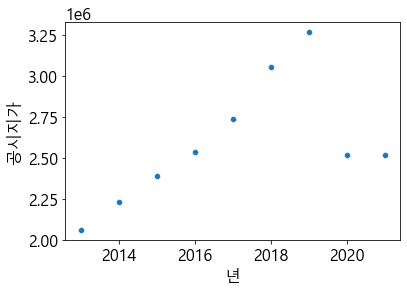

서울특별시 종로구 청운동 1-3


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


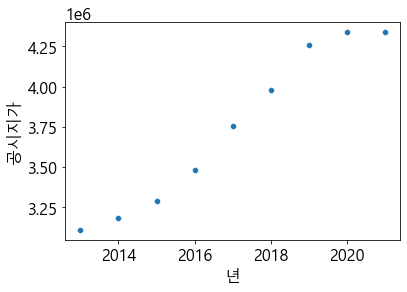

서울특별시 종로구 청운동 1-4


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


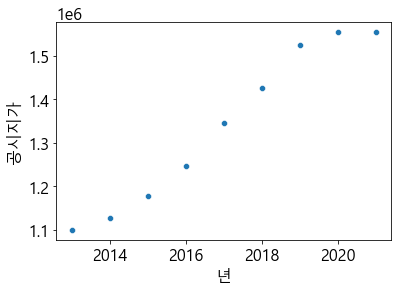

서울특별시 종로구 청운동 1-5


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


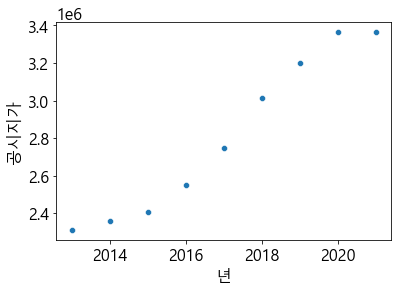

서울특별시 종로구 청운동 2-1


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


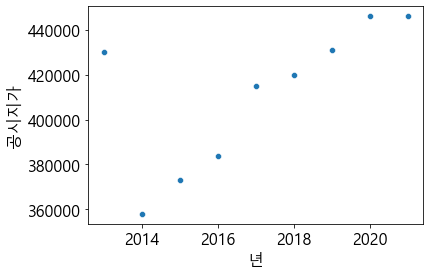

서울특별시 종로구 청운동 2-2


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


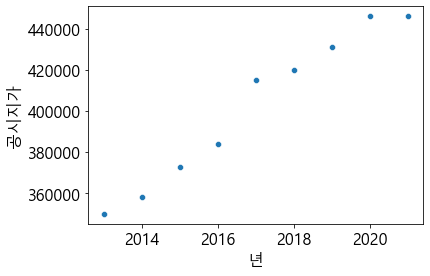

서울특별시 종로구 청운동 2-3


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


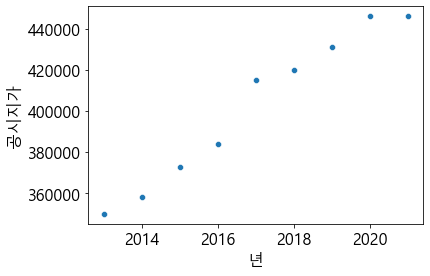

서울특별시 종로구 청운동 2-66


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


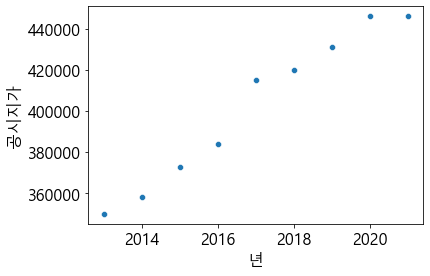

서울특별시 종로구 청운동 2-71


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


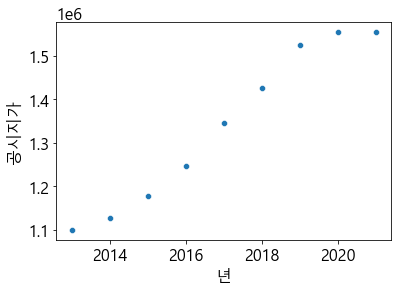

서울특별시 종로구 청운동 2-72


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


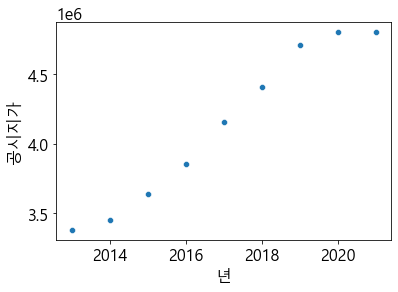

서울특별시 종로구 청운동 2-73


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


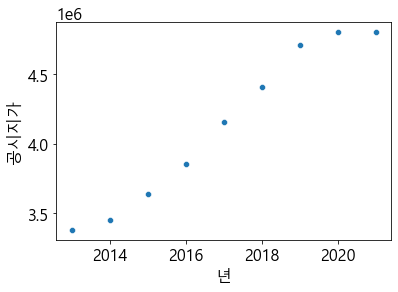

서울특별시 종로구 청운동 2-74


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


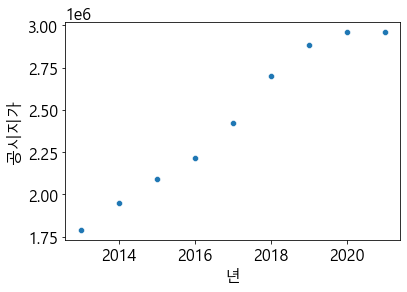

서울특별시 종로구 청운동 2-78


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


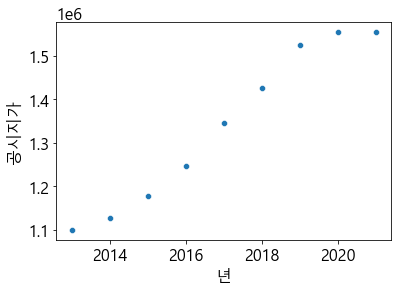

서울특별시 종로구 청운동 2-82


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


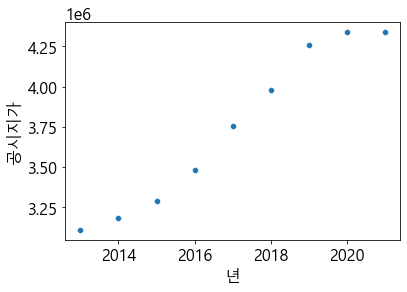

서울특별시 종로구 청운동 3-0


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


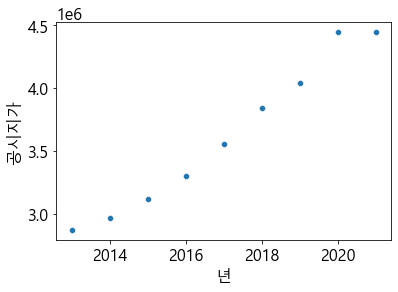

서울특별시 종로구 청운동 3-39


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


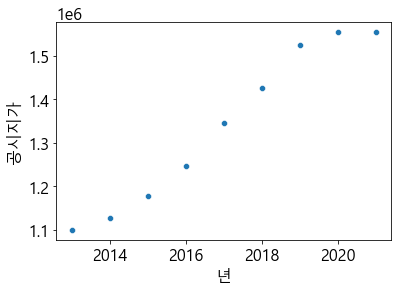

서울특별시 종로구 청운동 3-44


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


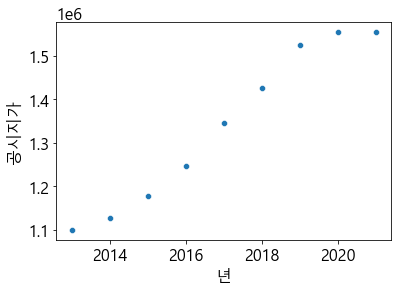

서울특별시 종로구 청운동 3-45


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


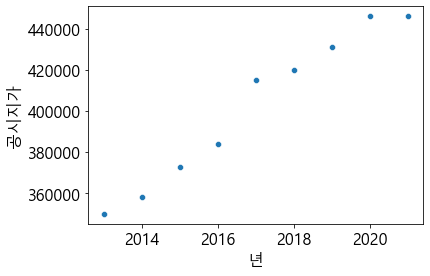

서울특별시 종로구 청운동 3-46


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


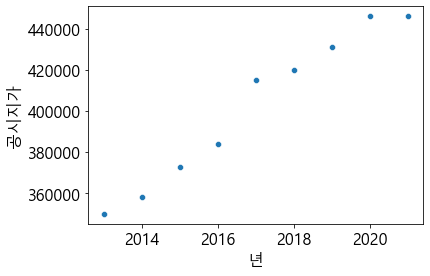

서울특별시 종로구 청운동 3-47


c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


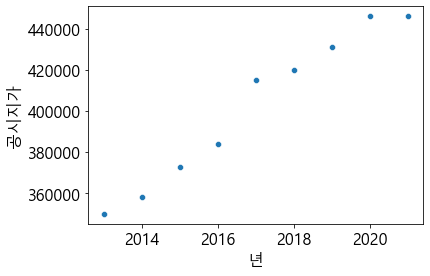

<Figure size 432x288 with 0 Axes>

In [52]:
for i, addr in enumerate(land_prices_df['지번주소'].unique()):
    print(addr)
    addr_df = land_prices_df[land_prices_df['지번주소'] == addr]
    
    empty_row = addr_df.iloc[[0],:]
    
    empty_row['년'] = 2021
    empty_row['공시지가'] = np.nan
    
    addr_df = pd.concat([addr_df, empty_row]).sort_values(['년']).reset_index(drop=True)
    
    sns.scatterplot(addr_df['년'], addr_df['공시지가'].interpolate(method='linear'))
    plt.show()
    plt.clf()
    
    if i > 20:
        break

In [26]:
interpolate_list = ['lnear', 'quadratic']

In [27]:
prac_df = land_prices_df[land_prices_df['지번주소'] == '서울특별시 종로구 청운동 1-2']

In [53]:
prac_df['공시지가'].dtype

dtype('float64')

In [54]:
prac_df['공시지가'] = prac_df['공시지가'].apply(float)

In [55]:
prac_df

,지번주소,표준지여부,년,공시지가
0,서울특별시 종로구 청운동 1-2,N,2013,2060000.0
1,서울특별시 종로구 청운동 1-2,N,2014,2230000.0
2,서울특별시 종로구 청운동 1-2,N,2015,2390000.0
3,서울특별시 종로구 청운동 1-2,N,2016,2533400.0
4,서울특별시 종로구 청운동 1-2,N,2017,2740000.0
5,서울특별시 종로구 청운동 1-2,N,2018,3056000.0
6,서울특별시 종로구 청운동 1-2,N,2019,3267000.0
7,서울특별시 종로구 청운동 1-2,N,2020,2520000.0
8,서울특별시 종로구 청운동 1-2,N,2021,NaN


In [29]:
empty_row = prac_df.iloc[[0],:]

In [30]:
empty_row

,지번주소,표준지여부,년,공시지가
66,서울특별시 종로구 청운동 1-2,N,2013,2060000


In [32]:
empty_row['년'] = 2021
empty_row['공시지가'] = np.nan

In [33]:
prac_df = pd.concat([prac_df, empty_row]).sort_values(['년']).reset_index(drop=True)

In [56]:
prac_df

,지번주소,표준지여부,년,공시지가
0,서울특별시 종로구 청운동 1-2,N,2013,2060000.0
1,서울특별시 종로구 청운동 1-2,N,2014,2230000.0
2,서울특별시 종로구 청운동 1-2,N,2015,2390000.0
3,서울특별시 종로구 청운동 1-2,N,2016,2533400.0
4,서울특별시 종로구 청운동 1-2,N,2017,2740000.0
5,서울특별시 종로구 청운동 1-2,N,2018,3056000.0
6,서울특별시 종로구 청운동 1-2,N,2019,3267000.0
7,서울특별시 종로구 청운동 1-2,N,2020,2520000.0
8,서울특별시 종로구 청운동 1-2,N,2021,NaN


In [65]:
prac_df['공시지가'].interpolate(method='linear', limit_direction='forward')

0    2060000.0
1    2230000.0
2    2390000.0
3    2533400.0
4    2740000.0
5    3056000.0
6    3267000.0
7    2520000.0
8    2520000.0
Name: 공시지가, dtype: float64

In [58]:
prac_df['공시지가'].interpolate(method='quadratic')

0    2060000.0
1    2230000.0
2    2390000.0
3    2533400.0
4    2740000.0
5    3056000.0
6    3267000.0
7    2520000.0
8          NaN
Name: 공시지가, dtype: float64

c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='년', ylabel='공시지가'>

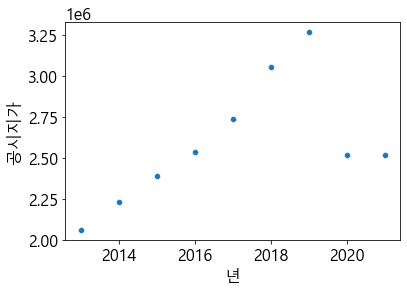

In [60]:
sns.scatterplot(prac_df['년'], prac_df['공시지가'].interpolate(method='linear'))

c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='년', ylabel='공시지가'>

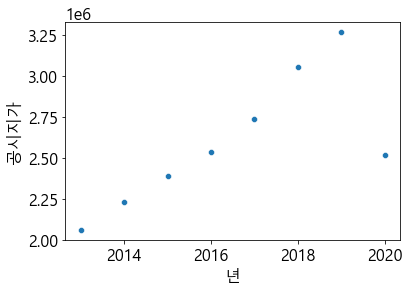

In [37]:
sns.scatterplot(prac_df['년'], prac_df['공시지가'].interpolate(method='quadratic'))

c:\users\max6296\ml\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='년', ylabel='공시지가'>

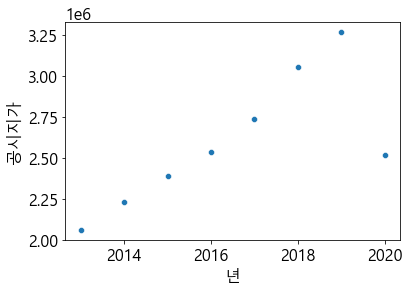

In [44]:
sns.scatterplot(prac_df['년'], prac_df['공시지가'].interpolate(method='from_derivatives'))

In [18]:
main_data_df = pd.read_csv('./prepped_data/main_data_baseline_checkpoint_1.csv')
print(main_data_df.shape)
main_data_df.head()

(4555253, 17)


,전월세매매구분,전용면적(㎡),계약일,금액(만원),월세(만원),층,건축년도,가격/면적,년,월,target_log_transformed,target/area_log_transformed,건물종류,지번주소,대장구분명,도로명주소,addr_split_len
0,매매,77.75,8,57000,0,2,1988,733.118971,2013,9,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,4.0
1,매매,77.75,16,57000,0,2,1988,733.118971,2013,12,10.950807,6.597308,아파트,서울특별시 강남구 개포동 655-2,일반,서울특별시 강남구 언주로 103-0,4.0
2,매매,67.28,11,55000,0,5,1987,817.479191,2013,2,10.915088,6.706225,아파트,서울특별시 강남구 개포동 658-1,일반,서울특별시 강남구 언주로 3-0,4.0
3,매매,67.28,22,58250,0,4,1987,865.784780,2013,2,10.972499,6.763636,아파트,서울특별시 강남구 개포동 658-1,일반,서울특별시 강남구 언주로 3-0,4.0
4,매매,67.28,10,60000,0,5,1987,891.795482,2013,5,11.002100,6.793237,아파트,서울특별시 강남구 개포동 658-1,일반,서울특별시 강남구 언주로 3-0,4.0


In [19]:
selected_df = land_prices_df[land_prices_df['지번주소'].isin(main_data_df['지번주소'].unique())]
print(selected_df.shape)
selected_df.head()

(1594565, 4)


,년,공시지가,표준지여부,지번주소
16,2006,2420000,N,서울특별시 종로구 청운동 1-0
17,2007,2580000,N,서울특별시 종로구 청운동 1-0
18,2008,2830000,N,서울특별시 종로구 청운동 1-0
19,2009,2770000,N,서울특별시 종로구 청운동 1-0
20,2010,2840000,N,서울특별시 종로구 청운동 1-0


In [20]:
selected_df.to_csv('./prepped_data/land_prices_ver_2.csv', index=False)